# Initialize

In [4]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchsummary import summary

from utils.dataset import EEGDataset
from utils.training import best_torch_device, train

In [5]:
# torch.manual_seed(3407)
torch.manual_seed(0)
np.random.seed(0)

In [6]:
%load_ext autoreload
%autoreload 2

## Constants

In [7]:
DEVICE = best_torch_device()
RAW = "raw"
SUB1 = "sub1"
FREQ = "frequency"

## Load Data

In [8]:
train_data = {}
valid_data = {}
test_data = {}

### Raw Data

In [9]:
X_train_data = np.load('data/X_train_valid.npy')
y_train_data = np.load('data/y_train_valid.npy')
X_test_data = np.load('data/X_test.npy')
y_test_data = np.load('data/y_test.npy')

split_idx = 1777
X_train_data, X_valid_data = X_train_data[:split_idx], X_train_data[split_idx:]
y_train_data, y_valid_data = y_train_data[:split_idx], y_train_data[split_idx:]

train_set = EEGDataset(X_train_data, y_train_data, label_smoothing=True)
valid_set = EEGDataset(X_valid_data, y_valid_data, label_smoothing=False)
test_set = EEGDataset(X_test_data, y_test_data, label_smoothing=False)

train_data[RAW] = DataLoader(train_set, batch_size=64, shuffle=True)
valid_data[RAW] = DataLoader(valid_set, batch_size=64, shuffle=False)
test_data[RAW] = DataLoader(test_set, batch_size=64, shuffle=False)

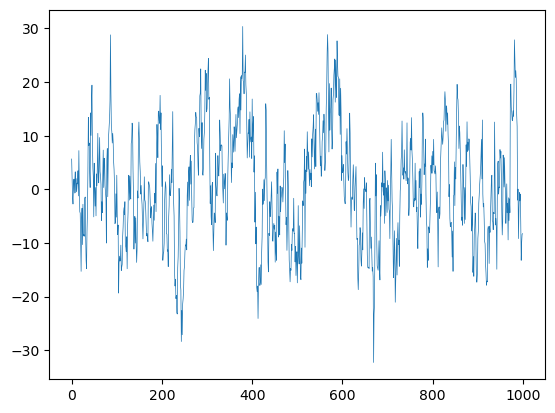

In [10]:
print("Training set shape:", X_train_data.shape, y_train_data.shape)
print("Validation set shape:", X_valid_data.shape, y_valid_data.shape)
print("Test set shape:", X_test_data.shape, y_test_data.shape)

Training set shape: (1777, 22, 1000) (1777,)
Validation set shape: (338, 22, 1000) (338,)
Test set shape: (443, 22, 1000) (443,)


### Sub1 Data

In [11]:
X_train_data = np.load('data/X_train_valid.npy')
y_train_data = np.load('data/y_train_valid.npy')
X_test_data = np.load('data/X_test.npy')
y_test_data = np.load('data/y_test.npy')

split_idx = 1777
X_train_data, X_valid_data = X_train_data[:199], X_train_data[1777:1815]
y_train_data, y_valid_data = y_train_data[:199], y_train_data[1777:1815]

test_person = np.load('data/person_test.npy')
sub0_index = (test_person == 0).reshape(-1)
X_test_data = X_test_data[sub0_index]
y_test_data = y_test_data[sub0_index]

train_set = EEGDataset(X_train_data, y_train_data, label_smoothing=True)
valid_set = EEGDataset(X_valid_data, y_valid_data, label_smoothing=False)
test_set = EEGDataset(X_test_data, y_test_data, label_smoothing=False)

train_data[SUB1] = DataLoader(train_set, batch_size=16, shuffle=True)
valid_data[SUB1] = DataLoader(valid_set, batch_size=16, shuffle=False)
test_data[SUB1] = DataLoader(test_set, batch_size=16, shuffle=False)

In [12]:
print("Training set shape:", X_train_data.shape, y_train_data.shape)
print("Validation set shape:", X_valid_data.shape, y_valid_data.shape)
print("Test set shape:", X_test_data.shape, y_test_data.shape)

Training set shape: (199, 22, 1000) (199,)
Validation set shape: (38, 22, 1000) (38,)
Test set shape: (50, 22, 1000) (50,)


### Frequency Data

In [13]:
X_train_data = np.load('data/generated/frequency/X_train_valid_augmented.npy')
y_train_data = np.load('data/generated/frequency/y_train_valid_augmented.npy')

split_idx = 1777
X_train_data, X_valid_data = X_train_data[:split_idx], X_train_data[split_idx:]
y_train_data, y_valid_data = y_train_data[:split_idx], y_train_data[split_idx:]

train_set = EEGDataset(X_train_data, y_train_data, label_smoothing=True)
valid_set = EEGDataset(X_valid_data, y_valid_data, label_smoothing=False)

train_data[FREQ] = DataLoader(train_set, batch_size=64, shuffle=True)
valid_data[FREQ] = DataLoader(valid_set, batch_size=64, shuffle=False)

In [14]:
print("Training set shape:", X_train_data.shape, y_train_data.shape)
print("Validation set shape:", X_valid_data.shape, y_valid_data.shape)

Training set shape: (1777, 22, 1000) (1777,)
Validation set shape: (4568, 22, 1000) (4568,)


# Model

In [47]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        # self.dropout = nn.Dropout(0.2)
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ResNet, self).__init__()
        self.initial_conv = nn.Conv1d(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = ResidualBlock(64, 64)
        self.layer2 = ResidualBlock(64, 64)
        # self.layer3 = ResidualBlock(64, 64)
        # self.layer4 = ResidualBlock(64, 64)
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        x = self.layer1(x)
        x = self.layer2(x)
        # x = self.dropout(x)
        # x = self.layer3(x)
        # x = self.layer4(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [48]:
test_model = ResNet(in_channels=22, num_classes=4)
test_model.forward(torch.rand(2, 22, 1000))
_ = summary(test_model, (22, 1000))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv1d: 1-1                            [-1, 64, 500]             9,920
├─BatchNorm1d: 1-2                       [-1, 64, 500]             128
├─ReLU: 1-3                              [-1, 64, 500]             --
├─MaxPool1d: 1-4                         [-1, 64, 250]             --
├─Dropout: 1-5                           [-1, 64, 250]             --
├─ResidualBlock: 1-6                     [-1, 64, 250]             --
|    └─Conv1d: 2-1                       [-1, 64, 250]             12,352
|    └─BatchNorm1d: 2-2                  [-1, 64, 250]             128
|    └─ReLU: 2-3                         [-1, 64, 250]             --
|    └─Conv1d: 2-4                       [-1, 64, 250]             12,352
|    └─BatchNorm1d: 2-5                  [-1, 64, 250]             128
|    └─ReLU: 2-6                         [-1, 64, 250]             --
├─ResidualBlock: 1-7                     [-1, 64, 250]             --
|

# Training

## Raw Data
Train on raw data, evaluate on raw data

In [49]:
raw_model = ResNet(in_channels=22, num_classes=4)
raw_model.to(DEVICE)

optimizer = torch.optim.Adam(raw_model.parameters(), lr=0.001, weight_decay=1e-03)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=raw_model,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_func=nn.CrossEntropyLoss(),
    train_data=train_data[RAW],
    val_data=valid_data[RAW],
    early_stopping_patience=30,
    cp_path="models/resnet",
    cp_filename="raw.pt",
    n_epochs=100,
    show_progress_bar=False,
)

Using device: cpu


[Epoch 0] val_acc=0.236686 train_acc=0.264491 val_loss=0.024605 train_loss=0.022442
Validation loss decreased (inf --> 0.024605).  Saving model ...
[Epoch 1] val_acc=0.251479 train_acc=0.303883 val_loss=0.024717 train_loss=0.021956
EarlyStopping counter: 1 out of 30
[Epoch 2] val_acc=0.269231 train_acc=0.330895 val_loss=0.026381 train_loss=0.021682
EarlyStopping counter: 2 out of 30
[Epoch 3] val_acc=0.349112 train_acc=0.332020 val_loss=0.023656 train_loss=0.021419
Validation loss decreased (0.024605 --> 0.023656).  Saving model ...
[Epoch 4] val_acc=0.242604 train_acc=0.386607 val_loss=0.032028 train_loss=0.020947
EarlyStopping counter: 1 out of 30
[Epoch 5] val_acc=0.266272 train_acc=0.397299 val_loss=0.025927 train_loss=0.020650
EarlyStopping counter: 2 out of 30
[Epoch 6] val_acc=0.298817 train_acc=0.416432 val_loss=0.025177 train_loss=0.020206
EarlyStopping counter: 3 out of 30
[Epoch 7] val_acc=0.328402 train_acc=0.440068 val_loss=0.027137 train_loss=0.019852
EarlyStopping counte

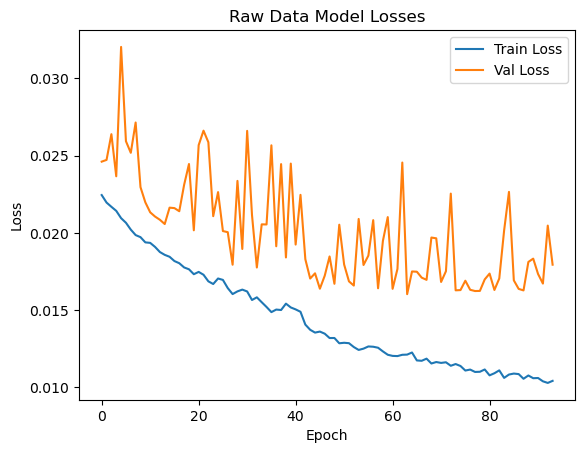

In [50]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Raw Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

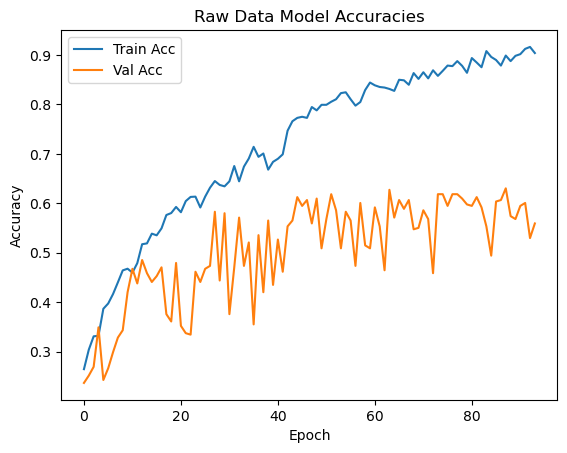

In [51]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Raw Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [52]:
# Load best model and test
raw_model = torch.load("models/resnet/raw.pt")
raw_model.to(DEVICE)
raw_model.eval()

ResNet(
  (initial_conv): Conv1d(22, 64, kernel_size=(7,), stride=(2,), padding=(3,))
  (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): ResidualBlock(
    (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (layer2): ResidualBlock(
    (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [53]:
# Evaluate on raw data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[RAW]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = raw_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[RAW].dataset)
print("Train on raw data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on raw data, evaluate on raw data
Test Acc: 0.6321


In [54]:
# Evaluate on sub1 data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[SUB1]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = raw_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[SUB1].dataset)
print("Train on raw data, evaluate on sub1 data")
print(f"Test Acc: {test_acc:.4f}")

Train on raw data, evaluate on sub1 data
Test Acc: 0.5800


## Sub1 Data    

In [130]:
sub1_model = ResNet(in_channels=22, num_classes=4)
sub1_model.to(DEVICE)

optimizer = torch.optim.Adam(sub1_model.parameters(), lr=0.001, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=sub1_model,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_func=nn.CrossEntropyLoss(),
    train_data=train_data[SUB1],
    val_data=valid_data[SUB1],
    early_stopping_patience=30,
    cp_path="models/resnet",
    cp_filename="sub1.pt",
    n_epochs=100,
    show_progress_bar=False,
)

Using device: cpu
[Epoch 0] val_acc=0.394737 train_acc=0.306533 val_loss=0.108806 train_loss=0.092019
Validation loss decreased (inf --> 0.108806).  Saving model ...
[Epoch 1] val_acc=0.289474 train_acc=0.371859 val_loss=0.099364 train_loss=0.083266
Validation loss decreased (0.108806 --> 0.099364).  Saving model ...
[Epoch 2] val_acc=0.289474 train_acc=0.482412 val_loss=0.098458 train_loss=0.077664
Validation loss decreased (0.099364 --> 0.098458).  Saving model ...
[Epoch 3] val_acc=0.236842 train_acc=0.497487 val_loss=0.115013 train_loss=0.072333
EarlyStopping counter: 1 out of 30
[Epoch 4] val_acc=0.236842 train_acc=0.502513 val_loss=0.150850 train_loss=0.072166
EarlyStopping counter: 2 out of 30
[Epoch 5] val_acc=0.236842 train_acc=0.592965 val_loss=0.119341 train_loss=0.068082
EarlyStopping counter: 3 out of 30
[Epoch 6] val_acc=0.342105 train_acc=0.597990 val_loss=0.094625 train_loss=0.066901
Validation loss decreased (0.098458 --> 0.094625).  Saving model ...
[Epoch 7] val_acc=

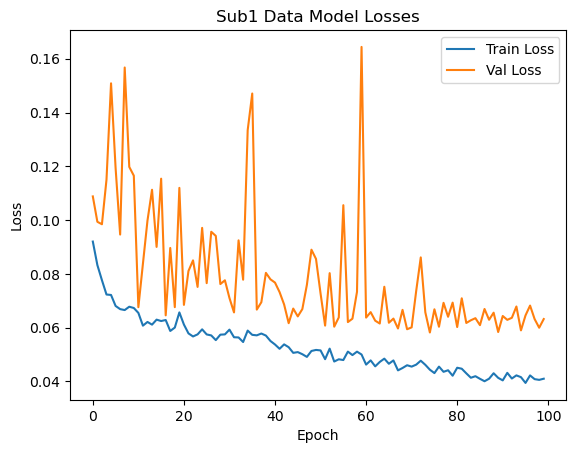

In [131]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Sub1 Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

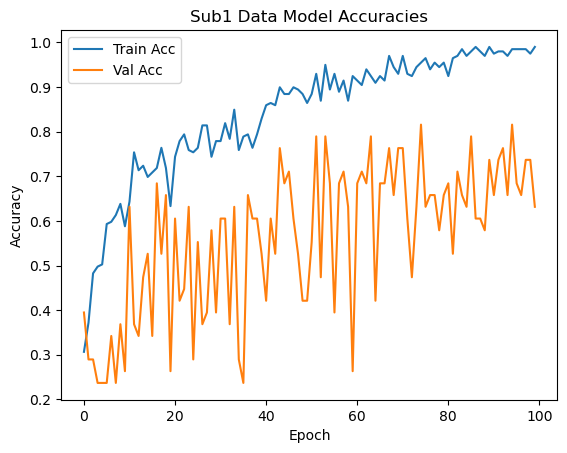

In [132]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Sub1 Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [133]:
# Load best model and test
sub1_model = torch.load("models/resnet/sub1.pt")
sub1_model.to(DEVICE)
sub1_model.eval()

ResNet(
  (initial_conv): Conv1d(22, 64, kernel_size=(7,), stride=(2,), padding=(3,))
  (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): ResidualBlock(
    (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (layer2): ResidualBlock(
    (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [134]:
# Evaluate on sub1 data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[SUB1]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = sub1_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[SUB1].dataset)
print("Train on sub1 data, evaluate on sub1 data")
print(f"Test Acc: {test_acc:.4f}")

Train on sub1 data, evaluate on sub1 data
Test Acc: 0.7600


In [135]:
# Evaluate on raw data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[RAW]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = sub1_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[RAW].dataset)
print("Train on sub1 data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on sub1 data, evaluate on raw data
Test Acc: 0.3770


## Frequency Data

In [136]:
freq_model = ResNet(in_channels=22, num_classes=4)
freq_model.to(DEVICE)

optimizer = torch.optim.Adam(freq_model.parameters(), lr=0.001, weight_decay=1e-03)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=freq_model,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_func=nn.CrossEntropyLoss(),
    train_data=train_data[FREQ],
    val_data=valid_data[RAW],
    early_stopping_patience=30,
    cp_path="models/resnet",
    cp_filename="freq.pt",
    n_epochs=100,
    show_progress_bar=False,
)

Using device: cpu
[Epoch 0] val_acc=0.236686 train_acc=0.274620 val_loss=0.025108 train_loss=0.022300
Validation loss decreased (inf --> 0.025108).  Saving model ...
[Epoch 1] val_acc=0.272189 train_acc=0.309510 val_loss=0.025498 train_loss=0.021914
EarlyStopping counter: 1 out of 30
[Epoch 2] val_acc=0.334320 train_acc=0.314012 val_loss=0.024583 train_loss=0.021673
Validation loss decreased (0.025108 --> 0.024583).  Saving model ...
[Epoch 3] val_acc=0.319527 train_acc=0.357907 val_loss=0.024711 train_loss=0.021217
EarlyStopping counter: 1 out of 30
[Epoch 4] val_acc=0.363905 train_acc=0.351154 val_loss=0.023412 train_loss=0.021104
Validation loss decreased (0.024583 --> 0.023412).  Saving model ...
[Epoch 5] val_acc=0.431953 train_acc=0.412493 val_loss=0.022873 train_loss=0.020466
Validation loss decreased (0.023412 --> 0.022873).  Saving model ...
[Epoch 6] val_acc=0.440828 train_acc=0.425436 val_loss=0.022366 train_loss=0.020094
Validation loss decreased (0.022873 --> 0.022366).  S

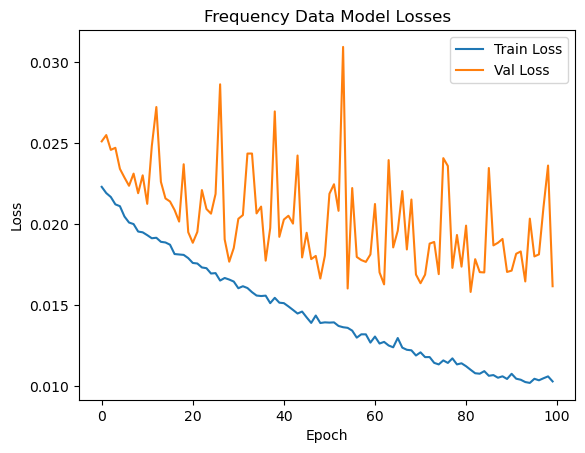

In [137]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Frequency Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

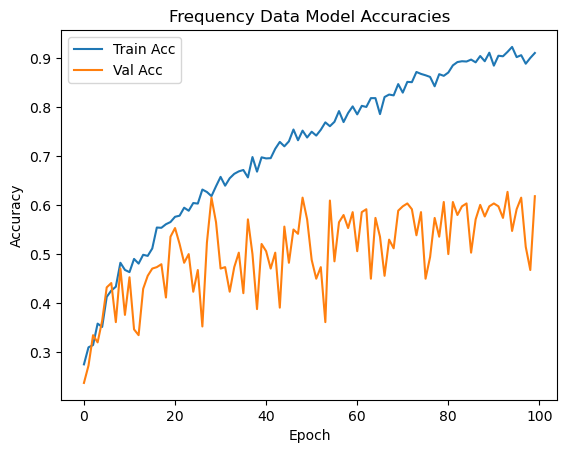

In [138]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Frequency Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [139]:
# Load best model and test
freq_model = torch.load("models/resnet/freq.pt")
freq_model.to(DEVICE)
freq_model.eval()

ResNet(
  (initial_conv): Conv1d(22, 64, kernel_size=(7,), stride=(2,), padding=(3,))
  (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): ResidualBlock(
    (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (layer2): ResidualBlock(
    (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [140]:
# Evaluate on frequency data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[RAW]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = freq_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[RAW].dataset)
print("Train on frequency data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on frequency data, evaluate on raw data
Test Acc: 0.6027
